In [1]:
import warnings
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay

warnings.filterwarnings('ignore')

In [2]:
# import MNIST dataset from openml not as frame
mnist = fetch_openml('mnist_784', as_frame=False) # large number of 28x28 images of numbers
type(mnist)

sklearn.utils._bunch.Bunch

In [3]:
# create X and y from mnist, X is the data, y is the target, 
# 70000 images
# each image is 28x28 pixels, stored in a 784-length array
# each feature simply represents one pixel's intensity, 
# from 0 (white) to 255 (black)
X, y = mnist.data, mnist.target

print(X)
print(X.shape)

# y is the number represented in the images in x. 
# so X[0] contains an image of the number in y[0]
print(y)
print(y.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(70000, 784)
['5' '0' '4' ... '4' '5' '6']
(70000,)


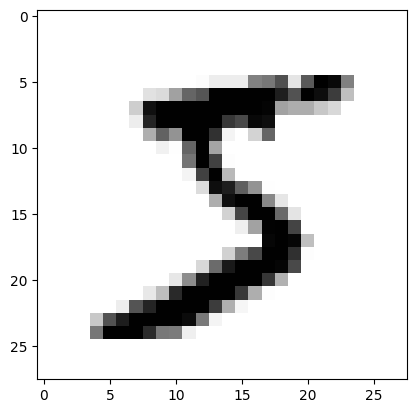

In [4]:
# show image 0
# we need to reshape the flat array of image 0 
# to a 28x28 array to show the image
plt.imshow(X[0].reshape(28, 28), cmap="binary");

In [5]:
# check the target of image 0
y[0]

'5'

In [6]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

In [7]:
# create a 5-detector, a binary classifier, 
# capable of distinguishing between just two classes, 5 and not-5
# create target vectors for this classification task
# True for all 5s, False for all other digits
y_train_5 = (y_train == '5') # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')
print(y_train_5, "\n\n", y_test_5)

[ True False False ...  True False False] 

 [False False False ... False  True False]


In [8]:
# create a SGDClassifier and train it on the whole training set
# SGDClassifier is a type of linear classifier trained using gradient descent
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
# use it to detect images of the number 5
# the `predict` method returns an array of predictions, one per image
# in this case, it returns True for 5's and False for all other digits
sgd_clf.predict([X[0], X[1]])

array([ True, False])

Observe predict takes as input an array or list of instances to predict. 

The classifier guesses that this image represents a 5 (True). Looks like it guessed right
in this particular case! Now, let’s evaluate this model’s performance.

# Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor.

## Measuring Accuracy Using Cross-Validation

In [10]:
# compute the accuracy of this classifier using cross-validation with 3 folds
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Wow! Above 95% accuracy (ratio of correct predictions) on all cross-validation folds?
This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a dummy
classifier that just classifies every single image in the most frequent class, which in
this case is the negative class (i.e., non 5):

In [11]:
# create a dummy classifier that just classifies every single image in the "not-5" class
# that is, it classifies every single image in the most frequent class
# accuracy will be around 90% because only about 10% of the images are 5s

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)

cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

## Confusion Matrices

In [12]:
# use cross_val_predict() function to perform K-fold cross-validation
# but instead of returning the evaluation scores, 
# return the predictions made on each test fold
# obtaining a prediction for each instance in the training set

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

Just like the `cross_val_score()` function, `cross_val_predict()` performs k-fold
cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. 

This means that you get a clean prediction for each instance in the training set. 

“clean” means “out-of-sample”: the model makes predictions on data that it never saw during training.

In [13]:
#x axis is the true value, top ==5, bottom !=5
# y axis is out guess, left==we think it's 5, right==we don't think it's 5
cm = confusion_matrix(y_train_5, y_train_pred, labels=[True, False])
print(cm)

'''
true positives  TP |  false negatives FN
-------------------+----------------------
false positives FP |  true negatives TN

'''

[[ 3530  1891]
 [  687 53892]]


'\ntrue positives  TP |  false negatives FN\n-------------------+----------------------\nfalse positives FP |  true negatives TN\n\n'

Each row in a confusion matrix represents an actual class, while each column represents
a predicted class.

In [14]:
# pretend we reached perfection
# create a confusion matrix for perfect predictions

y_train_perfect_predictions = y_train_5 # pretend we reached perfection

cm = confusion_matrix(y_train_5, y_train_perfect_predictions, labels=[True, False])

print(cm)

'''
this is the ideal value
'''

[[ 5421     0]
 [    0 54579]]


'\nthis is the ideal value\n'

# Precision and Recall

$$ 
\text{precision} = \frac{TP}{TP+FP}
$$


$$
 \text{recall} = \frac{TP}{TP + FN}
$$

In [15]:
'''
Precision and Recall are more popular ways to determine accuracy.
for both numbers, the closer to 1 the better, accuracy gets worse as the value approaches 0
'''
# compute precision and recall
precision_score(y_train_5, y_train_pred) # == 3530 / (687 + 3530)
'''
87% of positive guesses are correct.
17% of the time, if the program predicts true, the real answer is false
'''

'\n87% of positive guesses are correct.\n17% of the time, if the program predicts true, the real answer is false\n'

In [16]:
recall_score(y_train_5, y_train_pred) # == 3530 / (1891 + 3530)
'''
the program correctly identifies 65% of all true values
if the real answer is 5, than the program has a 65% chance of correctly guessing it
35% of the time, a real value of 5 is identified as not 5
'''

'\nthe program correctly identifies 65% of all true values\nif the real answer is 5, than the program has a 65% chance of correctly guessing it\n35% of the time, a real value of 5 is identified as not 5\n'

Now our 5-detector does not look as shiny as it did when we looked at its accuracy.

When it claims an image represents a 5, it is correct only 83.7% of the time. 

Moreover, it only detects 65.1% of the 5s.


Often convenient to combine precision and recall into a single metric called the
F1 score, the harmonic mean of precision and recall.

$$
F_1 = \frac{2}{\frac{1}{\text{precision}}+\frac{1}{\text{recall}}}
$$

In [17]:
# compute F1 score
f1_score(y_train_5, y_train_pred)
''' 
just like the above values, the closer to 1 the better. if F1==1, the dredictions are perfect. 
'''

' \njust like the above values, the closer to 1 the better. if F1==1, the dredictions are perfect. \n'

Increasing precision reduces recall, and vice versa. This is called the *precision/recall trade-off*.

A classifier computes a score based
on a decision function. 

If the score is greater than a threshold, it assigns
the instance to the positive class; otherwise it assigns it to the negative class.

In [18]:
# compute decision scores for some instances
# set the threshold manually to 0
# make predictions for some instances using the threshold

y_scores = sgd_clf.decision_function([X[0], X[1], X[2]])
print(y_scores)
''' 
the greater the value, the more sure it is.
positive means it predicts true value
negative means it predicts false value
'''

threshold = 0 # change this to change cutoff, or threshold. Higher value means more conservative predictions
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)
# by changing the threshold, we could say "anything below 100 is false", or things like that



[  2164.22030239  -5897.37359354 -13489.14805779]
[ True False False]


The `SGDClassifier` uses a threshold equal to 0, so the preceding code returns the
same result as the `predict()` method (i.e., `True`). Let’s raise the threshold:

In [19]:
# raise the threshold to 3000
# predict using the new threshold

threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False, False, False])

Raising the threshold decreases recall. 

How do you decide which threshold to use? 

Use the `cross_val_predict()` function to get the scores of all instances in the
training set, but this time specify that you want to return decision scores
instead of predictions:

In [20]:
# compute decision scores for all instances in the training set
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, 
                             cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

With these scores, use the `precision_recall_curve()` function to
compute precision and recall for all possible thresholds (the function adds
a last precision of 0 and a last recall of 1, corresponding to an infinite
threshold):

In [21]:
# compute precisions, recalls, and thresholds 
# using the precision_recall_curve() function
# print the shape of thresholds array
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores) #y_train_5 is true/false values, y_scores is how confident the program is
thresholds.shape # 6000 ways to set the threshold

(60000,)

In [22]:
precisions.shape # this is 1 larger to account for when the threshold is set to infinity, always guesses false

(60001,)

**Questions**: 

Why do we have 60,000 thresholds?

Why do we have 60,001 precisions?

Finally, use Matplotlib to plot precision and recall as functions of the
threshold value. Let’s show the threshold of 3,000 we selected:

'\ngreen line is % of time guesses true\ndotted blue line is % of time guesses false\n'

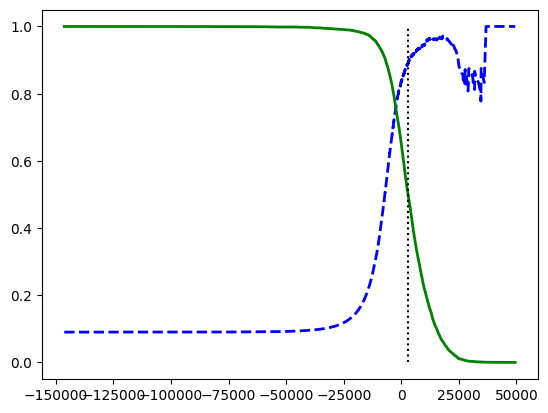

In [23]:
# plot precision and recall as functions of the threshold value
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2) # b-- is a blue dashed line
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2) # g- is a green solid line
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold") # 0 and 1.0 are the y axis limits for the vertical line

'''
green line is % of time guesses true
dotted blue line is % of time guesses false
'''

At this threshold value (3000), precision is near 90% and recall is around 50%.

In general, increasing the threshold typically lowers recall and increases precision. However, in rare cases, precision can also decrease. For example, consider scores and true labels: 1:F, 2:T, 3:T, 4:F, 5:T. For a threshold t=2, precision is 3/4 (0.75); for threshold t=4, precision is 1/2, which is lower. 

Another way to select a good precision/recall trade-off is to plot precision
directly against recall:

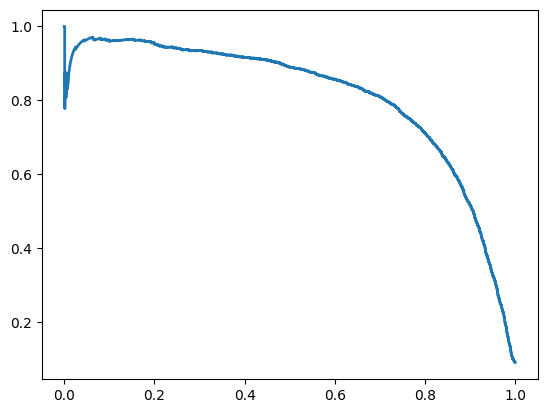

'\nx-axis is recalls\ny-axis is precision\n'

In [24]:
# plot precision directly against recall
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.show()
'''
x-axis is recalls
y-axis is precision
'''

You can see that precision really starts to fall sharply at around 80%
recall. You will probably want to select a precision/recall trade-off just
before that drop—for example, at around 60% recall. But of course, the
choice depends on your project.

Suppose you decide to aim for 90% precision. You could use the first plot
to find the threshold you need to use, but that’s not very precise.

Alternatively, you can search for the lowest threshold that gives you at
least 90% precision. For this, you can use the NumPy array’s `argmax()`
method. This returns the first index of the maximum value, which in this
case means the first True value:

In [25]:
# search for the lowest threshold that gives at least 90% precision
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

To make predictions (on the training set for now), instead of calling the
classifier’s `predict()` method, you can run this code:

In [26]:
# predict using the new threshold
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

Let’s check these predictions’ precision and recall:

In [27]:
# check precision and recall for the new threshold
print( precision_score(y_train_5, y_train_pred_90) )
print( recall_score(y_train_5, y_train_pred_90) )

0.9000345901072293
0.4799852425751706


Great, you have a 90% precision classifier! As you can see, it is fairly
easy to create a classifier with virtually any precision you want: just set a
high enough threshold, and you’re done. But wait, not so fast–a high precision
classifier is not very useful if its recall is too low! 
For many applications, 48% recall wouldn’t be great at all.

If someone says, “Let’s reach 99% precision”, you should ask, “At what recall?”

# The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool
used with binary classifiers. It is very similar to the precision/recall curve,
but instead of plotting precision versus recall, the ROC curve plots the
true positive rate (another name for recall) against the false positive rate
(FPR). 

The FPR (also called the fall-out) is the ratio of negative instances
that are incorrectly classified as positive. It is equal to 1 – the true
negative rate (TNR), which is the ratio of negative instances that are
correctly classified as negative. The TNR is also called *specificity*. 

Hence, the ROC curve plots *sensitivity* (recall) versus 1 – *specificity*.
To plot the ROC curve, you first use the `roc_curve()` function to
compute the TPR and FPR for various threshold values:

In [28]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

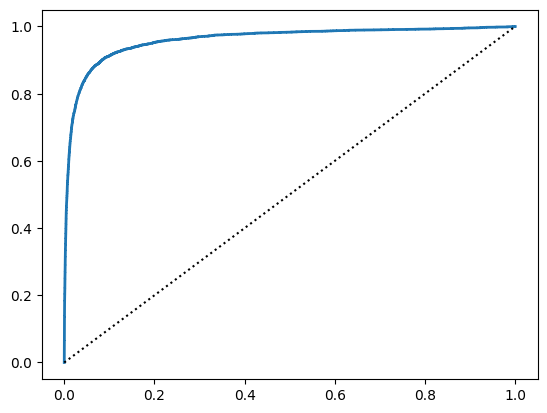

In [29]:
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")

Once again there is a trade-off: the higher the recall (TPR), the more false
positives (FPR) the classifier produces. The dotted line represents the
ROC curve of a purely random classifier; a good classifier stays as far
away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the area under the curve
(AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a
purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn
provides a function to estimate the ROC AUC:

In [30]:
roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

# Classifier Comparision

Let’s now create a `RandomForestClassifier`, whose PR curve and F
score we can compare to those of the `SGDClassifier`:

In [31]:
forest_clf = RandomForestClassifier(random_state=42)

The `precision_recall_curve()` function expects labels and scores
for each instance, so we need to train the random forest classifier and
make it assign a score to each instance. 

But the `RandomForestClassifier` class does not have a
`decision_function()` method, due to the way it works (we will cover this in Chapter 7). Luckily, it has a `predict_proba()` method that returns class probabilities for each instance, and we can just use the probability of the positive class as a score, so it will work fine. 

We can call the `cross_val_predict()` function to train the
RandomForestClassifier using cross-validation and make it predict
class probabilities for every image as follows:

In [32]:
y_probas_forest = cross_val_predict(forest_clf, X_train,y_train_5, 
                                    cv=3, method="predict_proba")

Let’s look at the class probabilities for the first two images in the training
set:

In [33]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

The model predicts that the first image is positive with 89% probability,
and it predicts that the second image is negative with 99% probability.

Since each image is either positive or negative, the probabilities in each
row add up to 100%.

The **second** column contains the estimated probabilities for the positive
class, so let’s pass them to the precision_recall_curve() function:

In [34]:
y_scores_forest = y_probas_forest[:, 1]

precisions_forest, recalls_forest, thresholds_forest = \
      precision_recall_curve(y_train_5, y_scores_forest)

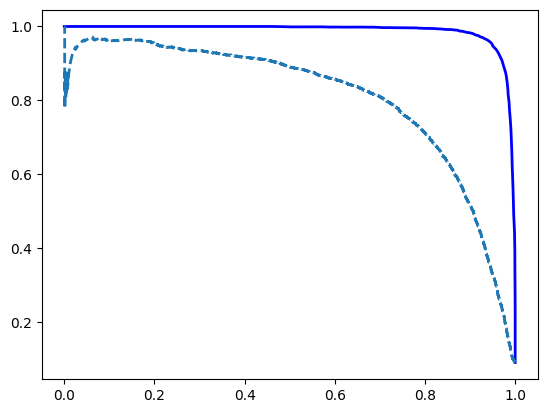

In [35]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.show()

As you can see, the RandomForestClassifier’s PR curve looks much better than the SGDClassifier’s: it comes much closer to the top-right corner. Its F score and ROC AUC score are also significantly better:

In [36]:
y_pred_forest = y_probas_forest[:, 1] >= 0.5
print( f1_score(y_train_5, y_pred_forest) )
print( roc_auc_score(y_train_5, y_scores_forest) )

0.9274509803921569
0.9983436731328145


Try measuring the precision and recall scores: you should find about
99.1% precision and 86.6% recall. Not too bad!

You now know how to train binary classifiers, choose the appropriate
metric for your task, evaluate your classifiers using cross-validation,
select the precision/recall trade-off that fits your needs, and use several
metrics and curves to compare various models. You’re ready to try to
detect more than just the 5s.

# Multiclass Classification

Whereas binary classifiers distinguish between two classes, multiclass
classifiers (also called multinomial classifiers) can distinguish between
more than two classes.

One way to create a system that can classify the digit images into 10
classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a
0-detector, a 1-detector, a 2-detector, and so on). Then when you want to
classify an image, you get the decision score from each classifier for that
image and you select the class whose classifier outputs the highest score.
This is called the one-versus-the-rest (OvR) strategy, or sometimes oneversus-
all (OvA).

Another strategy is to train a binary classifier for every pair of digits: one
to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s
and 2s, and so on. This is called the one-versus-one (OvO) strategy. If
there are N classes, you need to train N × (N – 1) / 2 classifiers. For the
MNIST problem, this means training 45 binary classifiers! When you want
to classify an image, you have to run the image through all 45 classifiers
and see which class wins the most duels. The main advantage of OvO is
that each classifier only needs to be trained on the part of the training set
containing the two classes that it must distinguish.

Some algorithms (such as support vector machine classifiers) scale
poorly with the size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small training
sets than to train few classifiers on large training sets. For most binary
classification algorithms, however, OvR is preferred.



Scikit-Learn detects when you try to use a binary classification algorithm
for a multiclass classification task, and it automatically runs OvR or OvO,
depending on the algorithm. Let’s try this with a support vector machine
classifier using the `sklearn.svm.SVC` class. We’ll only
train on the first 2,000 images, or else it will take a very long time:

In [37]:
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]) # y_train, not y_train_5

SVC(random_state=42)

In [40]:
some_digit_scores = svm_clf.decision_function([X[0]])
some_digit_scores


array([[ 3.79297828,  0.72949369,  6.06184129,  8.29800527, -0.29383983,
         9.30157597,  1.74723215,  2.77365456,  7.20601456,  4.82245092]])

The highest score is 9.3, and it’s indeed the one corresponding to class 5:

In [41]:
class_id = some_digit_scores.argmax()
class_id

np.int64(5)

When a classifier is trained, it stores the list of target classes in its
classes_ attribute, ordered by value. In the case of MNIST, the index of
each class in the classes_ array conveniently matches the class itself
(e.g., the class at index 5 happens to be class '5'), but in general you
won’t be so lucky; you will need to look up the class label like this:

In [40]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [41]:
svm_clf.classes_[class_id]

'5'

Training an `SGDClassifier` on a multiclass dataset and using it to make
predictions is just as easy:

In [42]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train[:10000], y_train[:10000])
sgd_clf.predict([X[0]])

array(['5'], dtype='<U1')

# Error Analysis

If this were a real project, you would now follow the steps in your machine
learning project checklist. You’d explore data
preparation options, try out multiple models, shortlist the best ones, finetune
their hyperparameters using GridSearchCV, and automate as
much as possible. 

Here, we will assume that you have found a promising
model and you want to find ways to improve it. One way to do this is to
analyze the types of errors it makes.

First, look at the confusion matrix. For this, you first need to make
predictions using the `cross_val_predict()` function; then you can
pass the labels and predictions to the `confusion_matrix()` function,
just like you did earlier. However, since there are now 10 classes instead
of 2, the confusion matrix will contain quite a lot of numbers, and it may
be hard to read.
A colored diagram of the confusion matrix is much easier to analyze. To
plot such a diagram, use the
`ConfusionMatrixDisplay.from_predictions()` function like this:

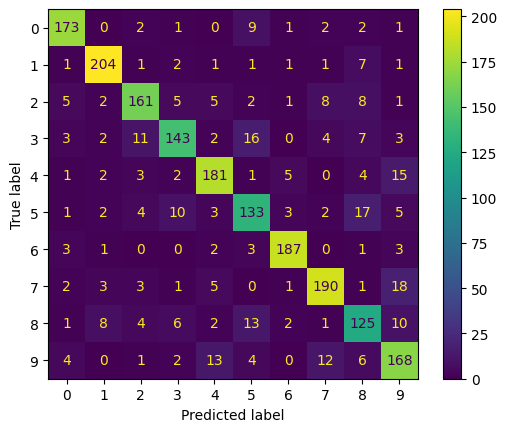

In [43]:
y_train_pred = cross_val_predict(sgd_clf, X_train[:2000], y_train[:2000], cv=3)
ConfusionMatrixDisplay.from_predictions(y_train[:2000], y_train_pred)
plt.show()

This produces the left diagram in Figure 3-9. This confusion matrix looks
pretty good: most images are on the main diagonal, which means that
they were classified correctly. Notice that the cell on the diagonal in row
\#5 and column \#5 looks slightly darker than the other digits. This could be
because the model made more errors on 5s, or because there are fewer
5s in the dataset than the other digits. That’s why it’s important to
normalize the confusion matrix by dividing each value by the total number
of images in the corresponding (true) class (i.e., divide by the row’s sum).
This can be done simply by setting normalize="true". We can also
specify the values_format=".0%" argument to show percentages with
no decimals.

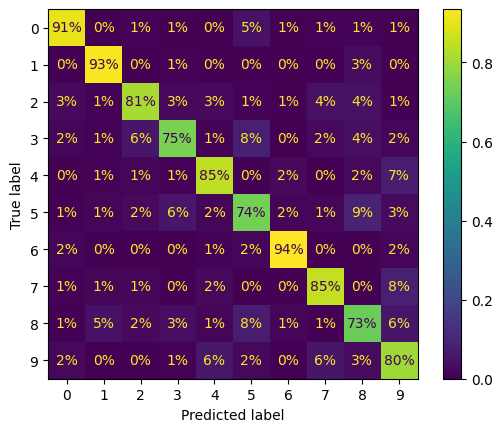

In [44]:
ConfusionMatrixDisplay.from_predictions(y_train[:2000], y_train_pred,normalize="true",values_format=".0%")
plt.show()

Now we can easily see that only 74% of the images of 5s were classified
correctly. The most common error the model made with images of 5s was
to misclassify them as 8s: this happened for 9% of all 5s. 

But only 8% of 8s got misclassified as 5s; confusion matrices are generally not
symmetrical! 

If you look carefully, you will notice that many digits have
been misclassified as 8s, but this is not immediately obvious from this
diagram. If you want to make the errors stand out more, you can try
putting zero weight on the correct predictions.

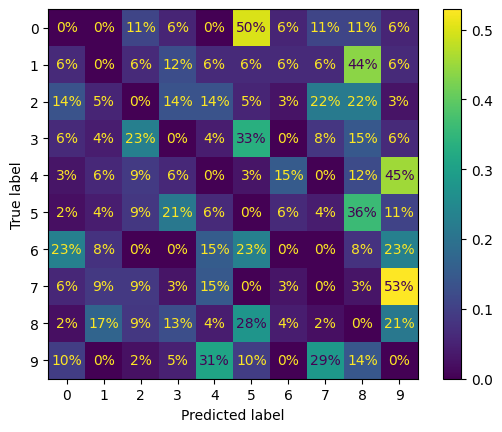

In [45]:
sample_weight = (y_train_pred != y_train[:2000])
ConfusionMatrixDisplay.from_predictions(y_train[:2000], y_train_pred, 
                                        sample_weight=sample_weight,
                                        normalize="true",
                                        values_format=".0%")
plt.show()

Now you can see much more clearly the kinds of errors the classifier
makes. The column for class 8 is now really bright, which confirms that
many images got misclassified as 8s. In fact this is the most common
misclassification for almost all classes. But be careful how you interpret
the percentages in this diagram: remember that we’ve excluded the
correct predictions. For example, the 36% in row #7, column #9 does not
mean that 36% of all images of 7s were misclassified as 9s. It means that
36% of the errors the model made on images of 7s were
misclassifications as 9s. In reality, only 3% of images of 7s were
misclassified as 9s.


It is also possible to normalize the confusion matrix by column rather than
by row: you set `normalize="pred"`. For example, you can see that 56% of misclassified 7s are actually 9s.

Analyzing the confusion matrix often gives you insights into ways to
improve your classifier. Looking at these plots, it seems that your efforts
should be spent on reducing the false 8s. For example, you could try to
gather more training data for digits that look like 8s (but are not) so that
the classifier can learn to distinguish them from real 8s. Or you could
engineer new features that would help the classifier—for example, writing
an algorithm to count the number of closed loops (e.g., 8 has two, 6 has
one, 5 has none). Or you could preprocess the images (e.g., using ScikitImage,
Pillow, or OpenCV) to make some patterns, such as closed loops,
stand out more.

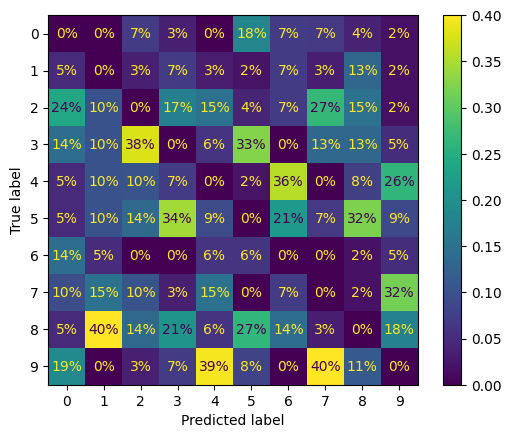

In [46]:
sample_weight = (y_train_pred != y_train[:2000])
ConfusionMatrixDisplay.from_predictions(y_train[:2000], y_train_pred, 
                                        sample_weight=sample_weight,
                                        normalize="pred",
                                        values_format=".0%")
plt.show()